# [Video](https://youtu.be/kT00ZcJ9f9E)


# Tableau de répartition des tâches

| Tâches || Guillaume | Antoine | Liliam | Pierre |
| --- || --- | --- | --- | --- |
| Color Histograms || x | x | x | --- |
| HU Moments || --- | --- | --- | x |
| Aspect Ratio || --- | --- | --- | x |
| DCT coefficients || --- | x | --- | --- |
| Early Fusion|| --- | --- | x |--- |
| Experimental Setup|| x | --- | --- |--- |

# Utils

In [1]:
%matplotlib notebook

In [2]:
def evaluate_classifier_shape(clf, X, Y):
    val_dict = cross_validate(clf, X, Y, cv=5, return_estimator=True)
    scores = val_dict["test_score"]
    estimators = val_dict["estimator"]
    
    return scores, estimators, estimators[np.argmax(scores)]

In [3]:
def evaluate_classifiers_shape(clfs, X, Y):
    estimators = []
    scores = []
    best_estimators = []
    
    for clf in clfs:
        val_dict = cross_validate(clf, X, Y, cv=4, return_estimator=True, scoring='f1_micro')
        estimators.append(val_dict["estimator"])
        scores.append(val_dict["test_score"])
        best_estimators.append(estimators[-1][np.argmax(scores[-1])])

    return scores, estimators, best_estimators

In [4]:
def evaluate_classifiers_shape_histo(clfs, X, Y, cv):
    f1_micro = []
    precision_micro = []
    recall_micro = []
    
    for clf in clfs:
        val_dict = cross_validate(clf, X, Y, cv=cv, scoring=['f1_micro', 'precision_micro', 'recall_micro'])
        f1_micro.append(np.mean(val_dict['test_f1_micro']))
        precision_micro.append(np.mean(val_dict['test_precision_micro']))
        recall_micro.append(np.mean(val_dict['test_recall_micro']))

    return np.array(f1_micro), np.array(precision_micro), np.array(recall_micro)

In [56]:
def optimize_feature_dim(feature, dim_range, classifiers, classifiers_names, Y, ax=None):
    perfs = [[] for _ in classifiers]
    for sub_feature in feature:
        scores, _, _, = evaluate_classifiers_shape(classifiers, sub_feature, Y)
        for i, cross_score in enumerate(scores):
            perfs[i].append(np.mean(cross_score))
    if ax is not None:
        for name, perf in zip(classifiers_names, perfs):
            ax.plot(dim_range, perf, label=name)
        ax.legend(loc="lower right")
        if issubclass(type(ax), plt.Axes):
            ax.set_xlabel("Dimension de la feature")
            ax.set_ylabel("F1 Score")
        else:
            ax.xlabel("Dimension de la feature")
            ax.ylabel("F1 Score")
    return {name: (perf.index(max(perf)) + dim_range[0], max(perf))
            for name, perf in zip(classifiers_names, perfs)}

## Loading the data

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from ipywidgets import interact
import ipywidgets as widgets

from dobble_master_race.toolkit import get_data_set

seed = 42 # Used for result reproductability

In [7]:
(X_train, Y_train), (X_test, Y_test) = get_data_set()
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((228,), (228,), (57,), (57,))

## What the data looks like ?

<IPython.core.display.Javascript object>


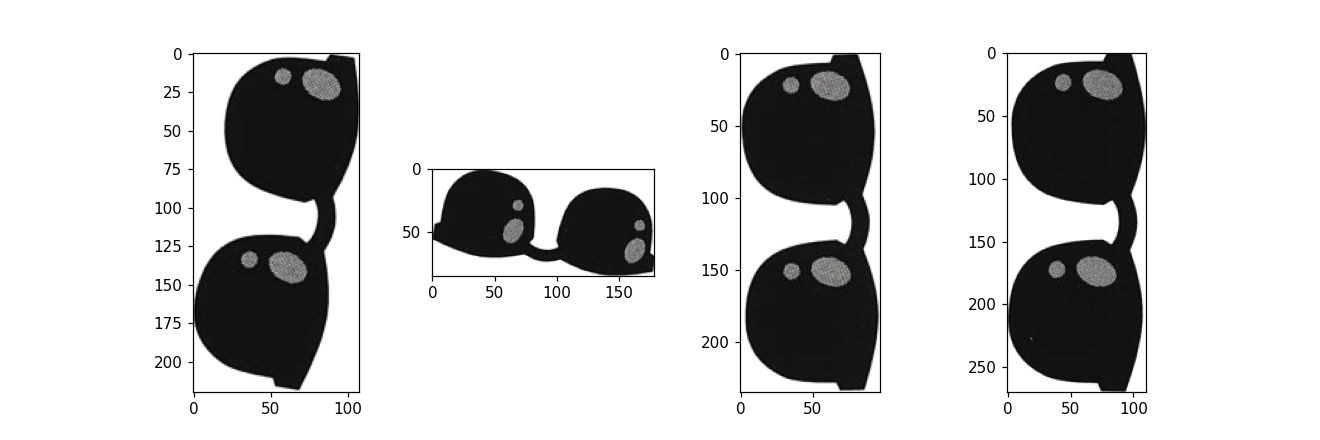

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [14]:
nb_class = np.max(Y_train)
nb_images_per_class = 4

_, ax_arr = plt.subplots(nrows=1, ncols=nb_images_per_class, figsize=(12,4))

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    for i, x in enumerate(X_train[Y_train == class_]):
        ax_arr[i].imshow(x)

## Apply median filter to reduce noise on printed images

In [16]:
X_train = np.array([cv2.medianBlur(img, 3, 0) for img in X_train], dtype=object)

## Results after filtering

<IPython.core.display.Javascript object>


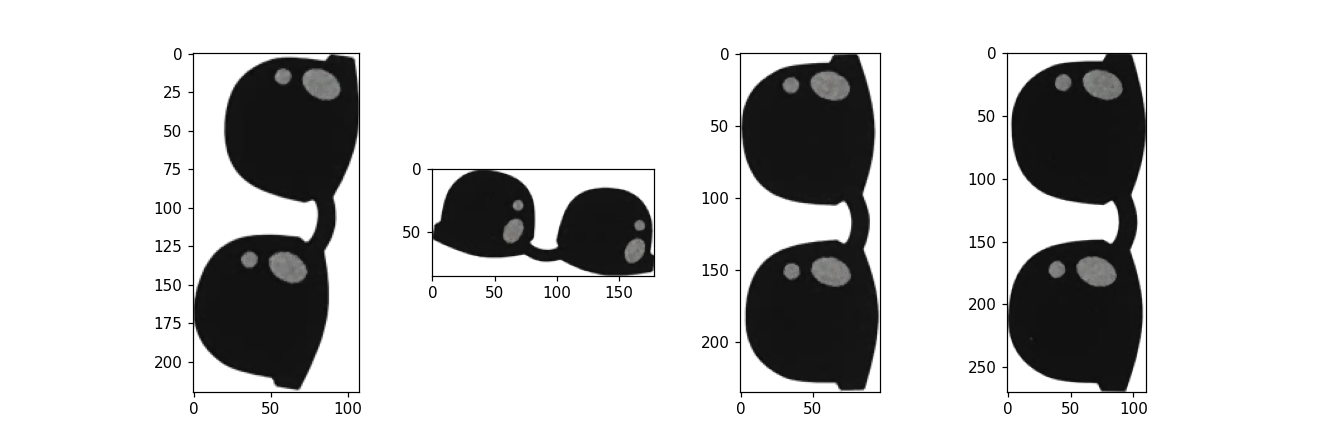

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [17]:
_, ax_arr = plt.subplots(nrows=1, ncols=4, figsize=(12,4))

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    for i, x in enumerate(X_train[Y_train == class_]):
        ax_arr[i].imshow(x)

# Classifiers choice and metrics

## Metrics
We base our evaluation system on solid, well-knowed metrics:
- F1-score
- Confusion Matrix

As all the classes have the same number of samples in it, we choose to compute the f1-score with a `micro` mean.

To mitigate the effect of the small size of the dataset on the evaluation, we have chosen to use a 4-cross-validation.\
This will keep under-control the high variance of performance such a dataset could have.\
The 5-cross-validation automatically separates the training and the testing set and evaluates the model on it for 5 different configuration.\
Checkout the [wikipedia page](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) to know more.

In [8]:
import pandas as pd
import seaborn as sn
from sklearn.model_selection import cross_validate

def print_confusion_matrix(predicted, actual) -> None:
    plt.figure(figsize=(11, 10))
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=True, bottom=True, top=True, labeltop=True)
    sn.heatmap(confusion_matrix, annot=True, vmax=np.max(confusion_matrix.max()[:-1]))

def get_perf_on_cross_validation(model, X, Y) -> None:
    """
    Compute & print the following metrics with an average on a 5-cross-validation for the given `model`:
    - F1-score
    - Confusion Matrix
    """
    model_perf = cross_validate(model, X, Y, cv=nb_images_per_class,
                                scoring=['f1_micro'], return_estimator=True)
    best_model = model_perf["estimator"][np.argmax(model_perf["test_f1_micro"])]
    print(f"F1-score: {np.mean(model_perf['test_f1_micro'])}")
    
    print_confusion_matrix(best_model.predict(X), Y)    

### Dummy baseline
The goal of this baseline is to illustrate the performance of a random classifier.
This will demonstrate the performance of our implementation.

In [9]:
from sklearn.dummy import DummyClassifier

DummyClassifier(strategy='uniform')

DummyClassifier(strategy='uniform')

## The classifiers
We based our choice of classifiers on the sklearn cheat-sheet.\
As we are in a classification problem and that we have less than 100k samples, we tried the following classifiers:
- LinearSVC
- KNN
- SVC
- Random Forest

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_validate

classifiers = [SVC(), KNeighborsClassifier(), RandomForestClassifier(), LinearSVC(max_iter=10000, tol=1e-4), DummyClassifier(strategy='uniform')]

<IPython.core.display.Javascript object>


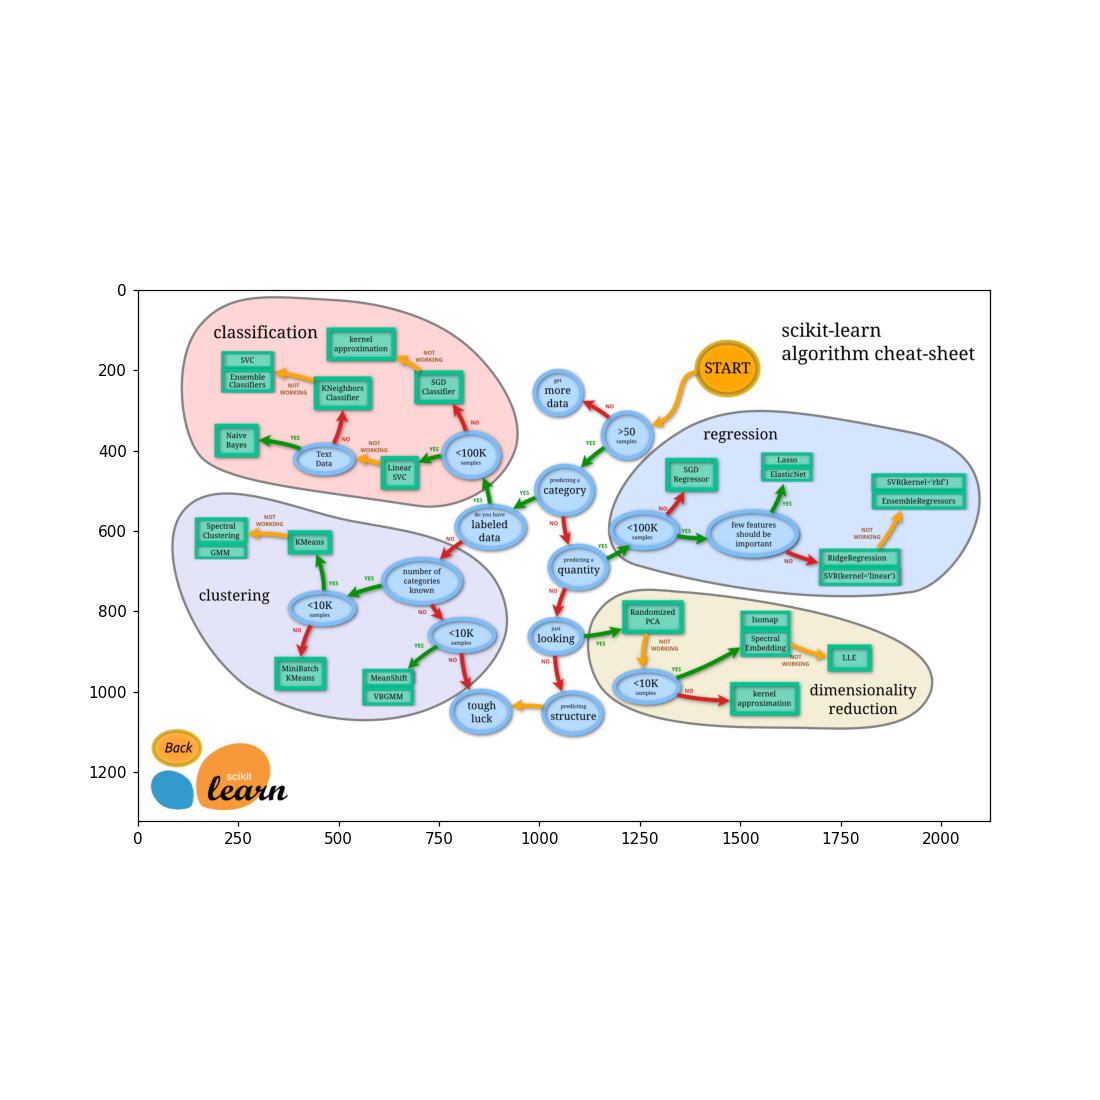

In [11]:
from PIL import Image
import urllib
from matplotlib import pyplot as plt

img = np.array(Image.open(urllib.request.urlopen("https://scikit-learn.org/stable/_static/ml_map.png")))
old_fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(img)
plt.rcParams["figure.figsize"] = old_fig_size;

# Color quantization & first evaluation of color histogram classifier

In this image classification problem, the image classes are significantly defined by their colors.\
Unfortunatly, the RGB space is way too broad and classifier will strugle to extract knowledge of it.\
Therefore, a preprocessing that reduces the numbers of colors, without sacrificing too much on the color description of class, will significantly improve its performance.

## Image mask
We are only interested in the colors from the image, not the blank background.\
We then need masks to extract the object from each images.\
We also take into account white pixels inside the shape.

<IPython.core.display.Javascript object>


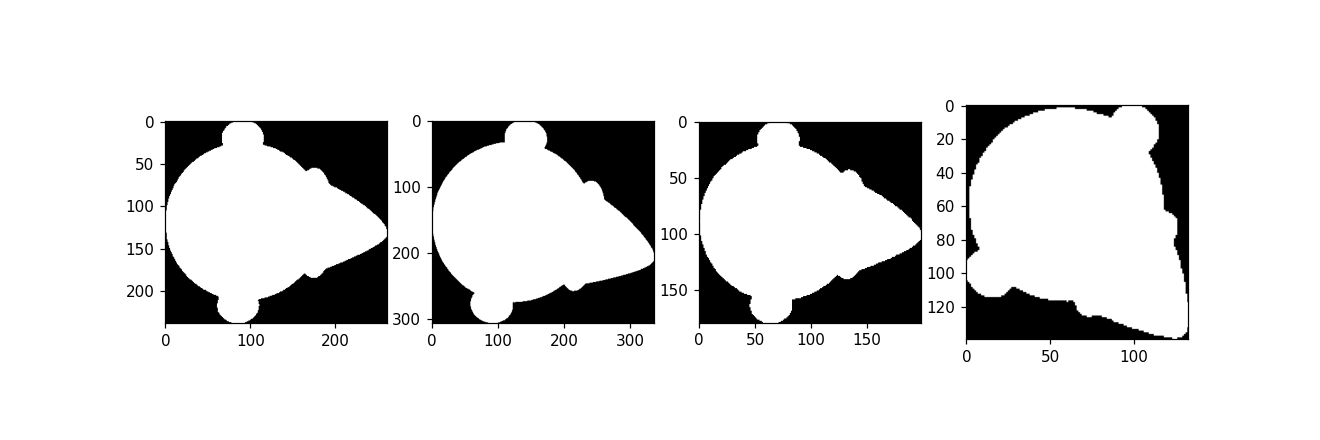

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [18]:
from dobble_master_race.img_utils import mask_with_inner

gray_threshold = 245

masks_train = np.array([mask_with_inner(img, gray_threshold) for img in X_train], dtype=object)
masks_test = np.array([mask_with_inner(img, gray_threshold) for img in X_test], dtype=object)

_, ax_arr = plt.subplots(nrows=1, ncols=4, figsize=(12,4))

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    for i, mask in enumerate(masks_train[Y_train == class_]):
        ax_arr[i].imshow(mask, cmap='gray')

## Sampling pixels

KMeans can a be a quite slow algorithm on large dataset. And in this application, we have `285` images * `~150x150` pixels per image = 6M+ pixels in total.\
Let's sample the number of pixels that will represent our dataset to make it faster.

In [20]:
nb_sample = 50000

nb_images = nb_class * nb_images_per_class
nb_sample_per_image = nb_sample // nb_images

sample_pxls = X_train[0][masks_train[0]][0] # Initialize arbitrary to be able to use np.vstack
for img, mask in zip(X_train[1:], masks_train[1:]):
    pxls = img[mask]
    new_sample_pxls_id = np.random.choice(pxls.shape[0], size=nb_sample_per_image, replace=False)
    sample_pxls = np.vstack((sample_pxls, pxls[new_sample_pxls_id]))

sample_pxls.shape, sample_pxls.dtype

((49714, 3), dtype('uint8'))

## Selecting color quantization threshold

In [21]:
from sklearn.cluster import KMeans
from tqdm import tqdm

# How to choose the right number of colors ?

inertias = []
new_colors = []
color_models = []
color_range = (2, 40)

# Compute new_colors and inertias and color_models
for i in tqdm(range(*color_range)):
    kmeans = KMeans(n_clusters=i, random_state=seed)
    
    kmeans.fit(sample_pxls)
    inertias.append(kmeans.inertia_)
    
    new_color = kmeans.cluster_centers_.astype(np.uint8)
    new_colors.append(new_color)
    
    color_models.append(kmeans)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [02:34<00:00,  4.08s/it]


<IPython.core.display.Javascript object>


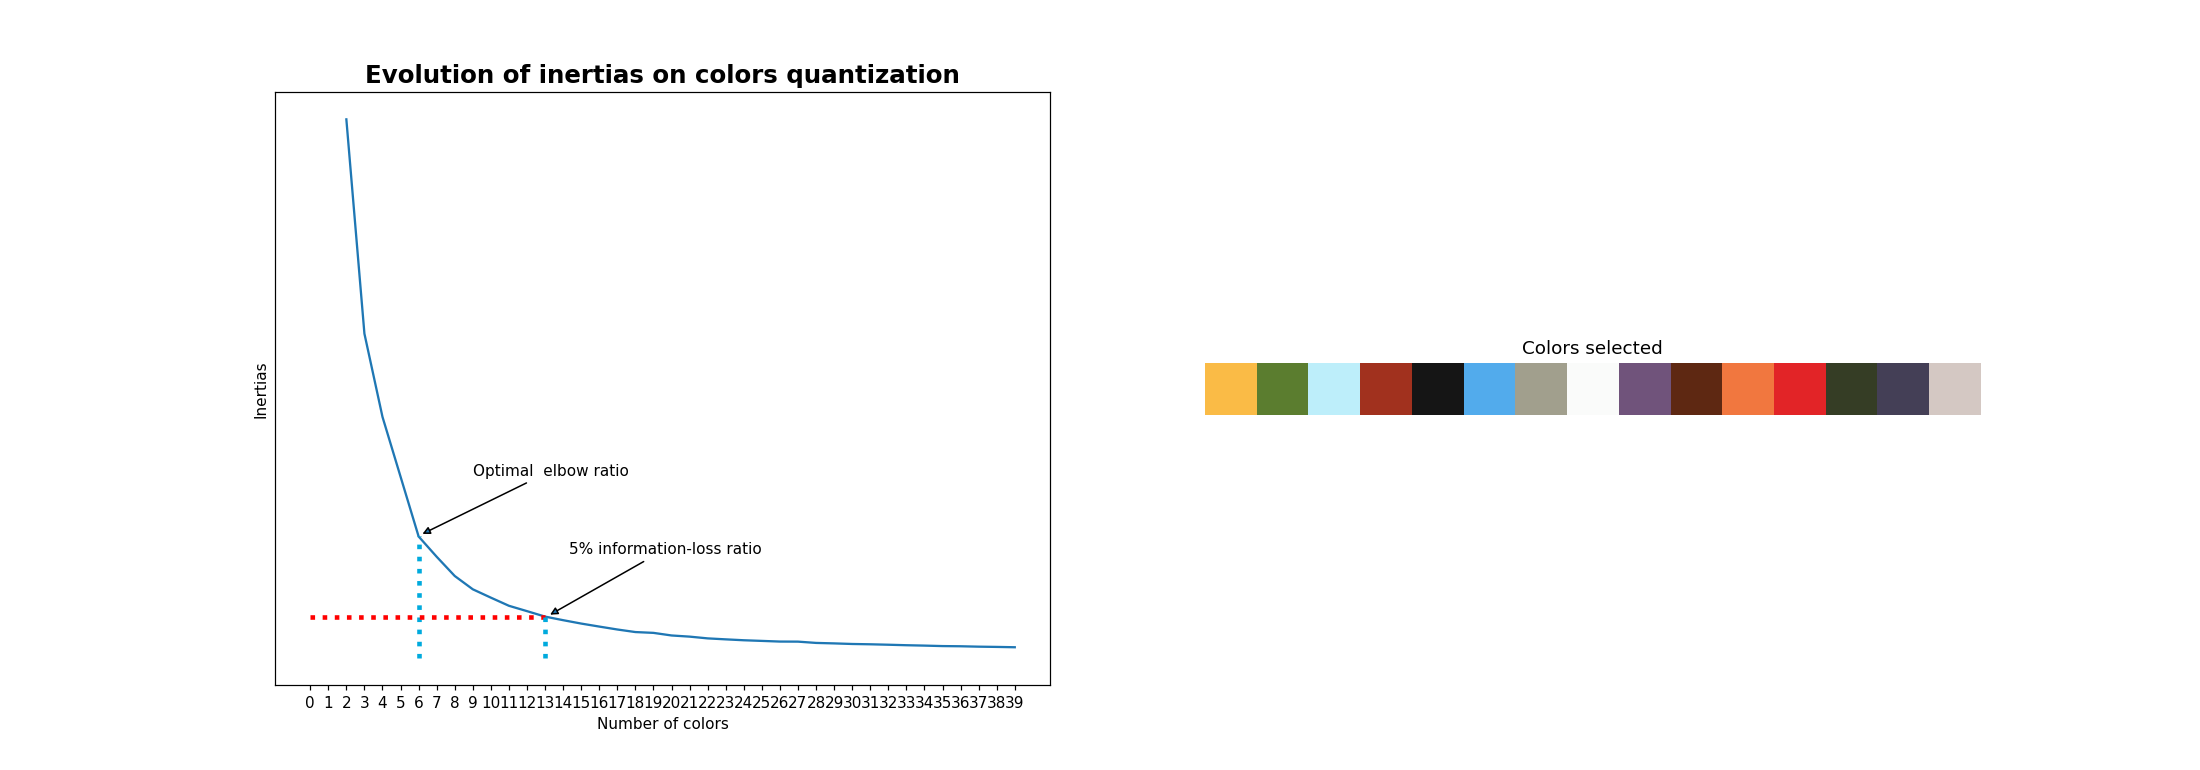

/tmp/ipykernel_1133075/3116730084.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_arr[1].set_xticklabels([1, 2, 7, 12, 17, 22, 27, 32, 37])


In [22]:
# Elbow optimum
nb_opti_color = 6

# Information threshold optimum
info_loss_threshold = 0.05 * (max(inertias) - min(inertias)) + min(inertias) # Accept 5% loss
info_loss_opti_color = np.searchsorted(-np.array(inertias), -info_loss_threshold, side="left")

# Figure
_, ax_arr = plt.subplots(ncols=2, figsize=(20,7))

# Plot new_colors
nb_tested_colors = color_range[1] - color_range[0]
new_color_img = np.full(shape=(color_range[1], 2 * nb_tested_colors - 1, 3), fill_value=255)

for i, new_color in enumerate(new_colors):
    new_color_img[:new_color.shape[0], i * 2] = np.array(sorted(new_color, key=lambda color: color[0] / 3 + color[1] / 3 + color[2] / 3))[np.newaxis, ...]

ax_arr[1].imshow(new_color_img, origin='lower')
ax_arr[1].set_title("Possible colors selection", fontsize=16, fontweight="semibold")
ax_arr[1].set_xlabel("Number of colors")
ax_arr[1].set_ylabel("Colors chosen")
ax_arr[1].set_xticklabels([1, 2, 7, 12, 17, 22, 27, 32, 37])
ax_arr[1].set_yticklabels([]); ax_arr[1].set_yticks([])
ax_arr[1].annotate(r"5% information-loss ratio", xy=((info_loss_opti_color - 2) * 2 * 1.01, (info_loss_opti_color - 1) * 1.05),
                   xytext=((info_loss_opti_color - 2 ) * 2 * 0.6, (info_loss_opti_color - 1) * 1.3), arrowprops=dict(arrowstyle="-|>"))
ax_arr[1].annotate(r"Optimal  elbow ratio", xy=((nb_opti_color - 2) * 2 * 1.01, (nb_opti_color - 1) * 1.1),
                   xytext=((nb_opti_color - 2 ) * 2 * 0.1, (nb_opti_color - 1) * 1.8), arrowprops=dict(arrowstyle="-|>"))

# Plot inertias
ax_arr[0].plot(range(*color_range), inertias)
ax_arr[0].set_title("Evolution of inertias on colors quantization", fontsize=16, fontweight="semibold")
ax_arr[0].set_xlabel("Number of colors")
ax_arr[0].set_ylabel("Inertias")
ax_arr[0].set_yticklabels([]); ax_arr[0].set_yticks([])
ax_arr[0].set_xticks(range(color_range[-1]))
ax_arr[0].plot([nb_opti_color, nb_opti_color],[0, inertias[nb_opti_color - color_range[0]]],':', color = '#00aadd', lw=3)
ax_arr[0].annotate(r"Optimal  elbow ratio", xy=(nb_opti_color * 1.01, inertias[nb_opti_color - color_range[0]] * 1.01),
                   xytext=(nb_opti_color * 1.5, inertias[nb_opti_color - color_range[0]] * 1.5), arrowprops=dict(arrowstyle="-|>"))
ax_arr[0].plot([0, info_loss_opti_color],[inertias[info_loss_opti_color - color_range[0]], inertias[info_loss_opti_color - color_range[0]]],':', color = '#ff0000', lw=3)
ax_arr[0].annotate(r"5% information-loss ratio", xy=(info_loss_opti_color * 1.01, inertias[info_loss_opti_color - color_range[0]] * 1.01),
                   xytext=(info_loss_opti_color * 1.1, inertias[info_loss_opti_color - color_range[0]] * 2.5), arrowprops=dict(arrowstyle="-|>"))
ax_arr[0].plot([info_loss_opti_color, info_loss_opti_color],[0, inertias[info_loss_opti_color - color_range[0]]],':', color = '#00aadd', lw=3);

There are usually 2 approaches to choose a color quantization threshold:
- Elbow method: Find an optimal $\frac{information-loss}{complexity}$ ratio
- Threshold method: Use a information-loss acceptance threshold (e.g. 5%)

We can see here, the two ratios in action.

Here, we can see on the left, the inertias curve for the number of colors selected. Based on the elbow method, we can say that a number of colors of 6 seems to be an optimal ratio between information lost (a.k.a inertias) and high complexity (a.k.a high number of colors).

In [23]:
# Example of color sampling
nb_color = 15

color_model = color_models[nb_color - color_range[0]]
new_color_lut = new_colors[nb_color - color_range[0]]

plt.imshow(new_color_lut[np.newaxis, :, :]); plt.axis("off"); plt.title("Colors selected");

In [24]:
import sklearn

def get_color_maps(X: np.array, masks: np.array, color_model: sklearn.cluster) -> np.array:
    return np.array([
        color_model.predict(img[mask])
        for img, mask in zip(X, masks)
    ], dtype=object)

color_maps_train = get_color_maps(X_train, masks_train, color_model)

def get_recolored_img(img: np.array, mask: np.array, color_map: np.array, *, background_color=255) -> np.array:
    recolored_img = np.full_like(img, background_color)
    recolored_img[mask] = new_color_lut[color_map]
    
    return recolored_img

def recolor_X(X: np.array, masks: np.array, color_model: sklearn.cluster, *, color_maps: np.array = None) -> np.array:
    if (color_maps is None):
        color_maps = get_color_maps(X, masks, color_model)
        
    return np.array([
        get_recolored_img(img, mask, color_map)
        for img, mask, color_map in zip(X, masks, color_maps)
    ], dtype=object)

recolored_X_train = recolor_X(X_train, masks_train, color_model)
recolored_X_test  = recolor_X(X_test,  masks_test, color_model)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    fig = plt.figure(constrained_layout=True, figsize=(12,4))
    subfigs = fig.subfigures(nrows=2, ncols=1)
    ax_recolored = subfigs[0].subplots(nrows=1, ncols=nb_images_per_class); subfigs[0].suptitle("Recolored", fontsize=16)
    ax_original  = subfigs[1].subplots(nrows=1, ncols=nb_images_per_class); subfigs[1].suptitle("Original", fontsize=16)
    
    for i, (recolored_x, x) in enumerate(zip(recolored_X_train[Y_train == class_], X_train[Y_train == class_])):
        ax_recolored[i].imshow(recolored_x)
        ax_original[i].imshow(x)
        ax_recolored[i].axis("off"); ax_original[i].axis("off")

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

Regardons de plus prêt les effets de la color quantization sur nos images. On peut voir que le seuil actuel de color quantization modifie significativement certaines images.\
C'est notamment le cas sur les images de la class 10, représentant un point d'intérogation. En effet, le léger bruit qu'il y avait dans notre image orignial est significativement amplifié.\
On peut se demander les effets que cela peut avoir sur les performances de notre classifier. Nous étudierons et mesurerons cet effet plus tard.

## Color descriptor
We now need to find an appropriate color descriptor. \
The color histogram is usually a good choice in this case as it is both really compact and discriminative. We will also see, that the noise of the color quantization won't impact that much the performance of the classifier on the color histogram.

### Computation of the color histograms

<IPython.core.display.Javascript object>


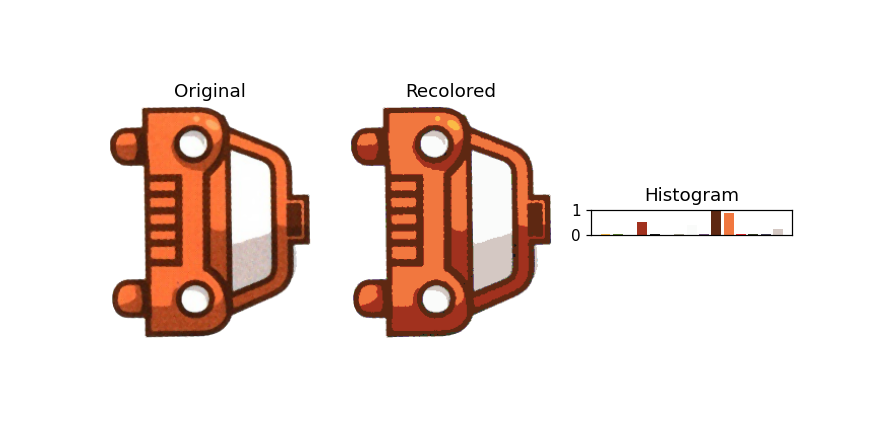

interactive(children=(BoundedIntText(value=0, description='x_index', max=228), Output()), _dom_classes=('widge…

In [26]:
def get_hist(color_map: np.array, *, nb_color=nb_color) -> np.array:
    hist = np.bincount(color_map, minlength=nb_color)
    norm_hist = hist / color_map.shape[0]
    
    return norm_hist

def compute_histograms(color_maps: np.array, *, nb_color=nb_color) -> np.array:
    return np.array([get_hist(color_map, nb_color=nb_color) for color_map in color_maps], dtype=object)

color_histograms_train = compute_histograms(color_maps_train)
color_histograms_train = compute_histograms(color_maps_train)

colors_for_bars = new_color_lut / 255  # matplotlib colors are RGB values scaled to [0,1]

_, ax_arr = plt.subplots(nrows=1, ncols=3, figsize=(8,4))

@interact(x_index=widgets.BoundedIntText(max=X_train.shape[0]))
def show_histograms(x_index: int) -> None:
    ax_arr[0].imshow(X_train[x_index])
    ax_arr[0].set_axis_off()
    ax_arr[0].set_title("Original")

    ax_arr[1].imshow(recolored_X_train[x_index])
    ax_arr[1].set_axis_off()
    ax_arr[1].set_title("Recolored")
    
    #plt.subplot(1,3,3, aspect=len(color_histograms[0]))
    ax_arr[2].clear()
    ax_arr[2].set_ylim(0, 1)
    ax_arr[2].set_aspect(nb_color)
    ax_arr[2].bar(range(len(color_histograms_train[x_index])), 
            color_histograms_train[x_index] / color_histograms_train[x_index].max(), 
            color=colors_for_bars)
    ax_arr[2].set_xticks([])
    ax_arr[2].set_title("Histogram")

# Classifiers cross validation

In [29]:
f1_score, _, best_estimators = evaluate_classifiers_shape(classifiers, color_histograms_train, Y_train)

for clf, scs in zip(classifiers, f1_score):
    print(f"{type(clf).__name__} scores:", np.mean(scs))

best_svc, best_knn, best_rnd, best_lsvc, best_dummy = best_estimators

SVC scores: 0.9780701754385964
KNeighborsClassifier scores: 0.9429824561403508
RandomForestClassifier scores: 0.9912280701754386
LinearSVC scores: 0.5921052631578948
DummyClassifier scores: 0.013157894736842105


F1-score: 0.9824561403508771


<IPython.core.display.Javascript object>


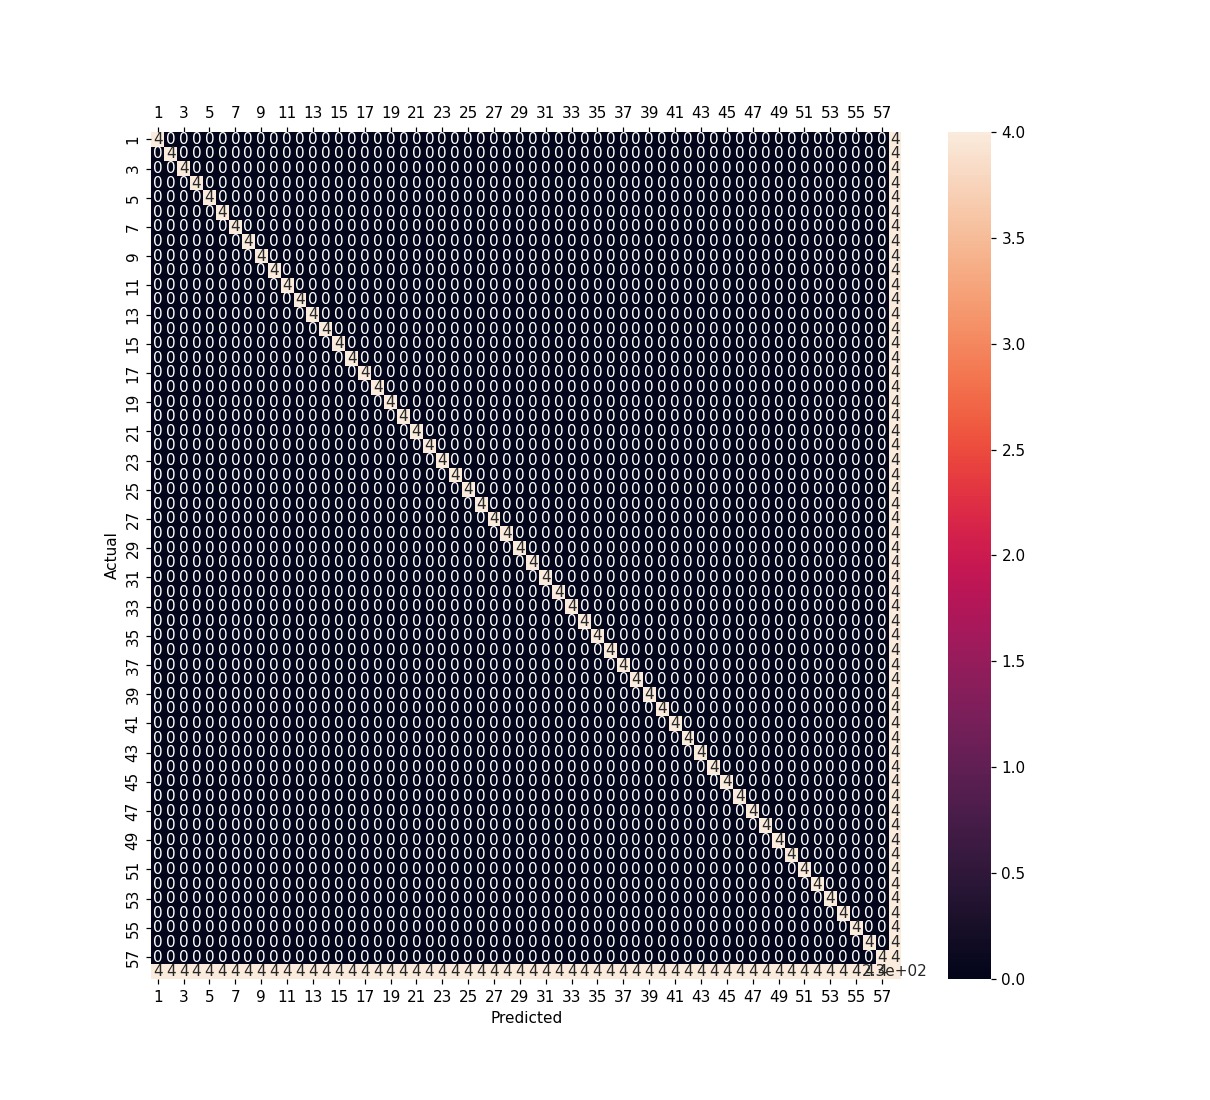

In [31]:
get_perf_on_cross_validation(best_rnd, color_histograms_train, Y_train)

## Peut-on ameliorer les resultats du classifier en changeant la color quanitzation ?

In [30]:
def recolor_and_compute_histograms(X: np.array, masks: np.array, color_model: sklearn.cluster, *, nb_color) -> np.array:
    color_maps = get_color_maps(X, masks, color_model)
    return compute_histograms(color_maps, nb_color=nb_color)

def get_score(classifier, color_histograms: np.array, Y: np.array) -> float:
    return np.mean(cross_validate(classifier, color_histograms, Y, cv=nb_images_per_class)["test_score"])

linear_svc_perf = []
svc_perf = []
knn_perf = []

for nb_color, color_model in tqdm(list(enumerate(color_models, start=color_range[0]))):
    new_color_histograms = recolor_and_compute_histograms(X_train, masks_train, color_model, nb_color=nb_color)
    linear_svc_perf.append(get_score(best_lsvc, new_color_histograms, Y_train))
    svc_perf.append(get_score(best_svc, new_color_histograms, Y_train))
    knn_perf.append(get_score(best_knn, new_color_histograms, Y_train))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:36<00:00,  1.04it/s]


<IPython.core.display.Javascript object>


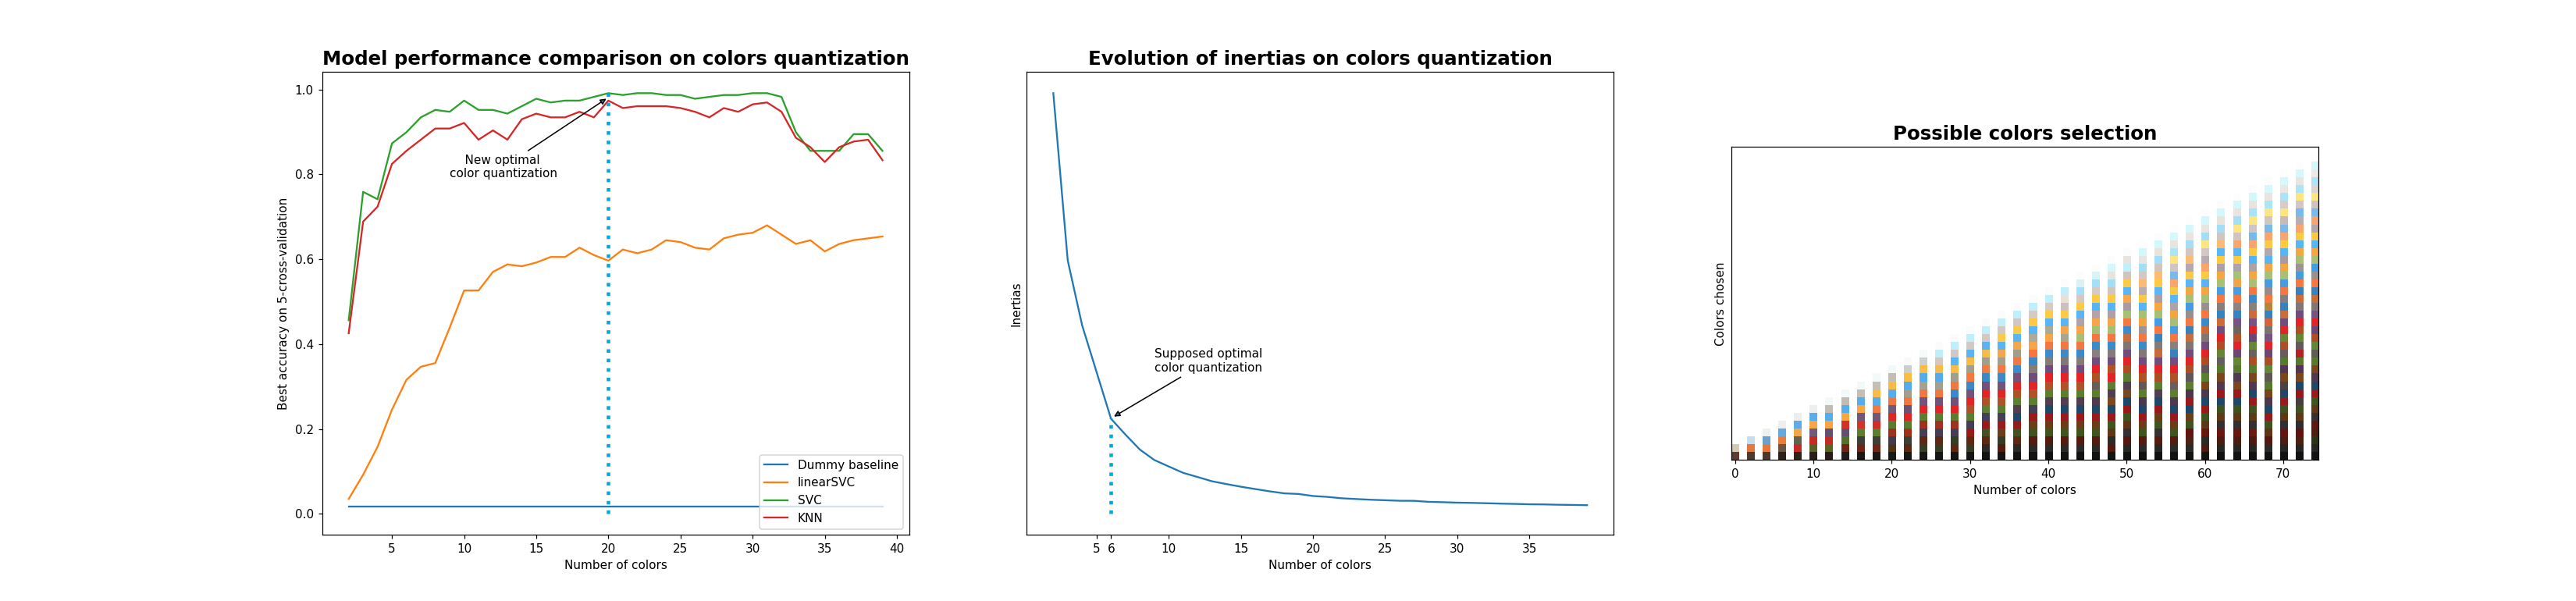

In [31]:
nb_opti_color = 6
_, ax_arr = plt.subplots(ncols=3, figsize=(30,7))
    
# Plot new_colors
nb_tested_colors = color_range[1] - color_range[0]
new_color_img = np.full(shape=(color_range[1], 2 * nb_tested_colors - 1, 3), fill_value=255)

for i, new_color in enumerate(new_colors):
    new_color_img[:new_color.shape[0], i * 2] = np.array(sorted(new_color, key=lambda color: color[0] / 3 + color[1] / 3 + color[2] / 3))[np.newaxis, ...]

ax_arr[2].imshow(new_color_img, origin='lower')
ax_arr[2].set_title("Possible colors selection", fontsize=16, fontweight="semibold")
ax_arr[2].set_xlabel("Number of colors")
ax_arr[2].set_ylabel("Colors chosen")
ax_arr[2].set_yticklabels([]); ax_arr[2].set_yticks([])

# Plot inertias
ax_arr[1].plot(range(*color_range), inertias)
ax_arr[1].set_title("Evolution of inertias on colors quantization", fontsize=16, fontweight="semibold")
ax_arr[1].set_xlabel("Number of colors")
ax_arr[1].set_ylabel("Inertias")
ax_arr[1].set_yticklabels([]); ax_arr[1].set_yticks([])
ax_arr[1].set_xticks(list(range(0, color_range[-1], 5)) + [6])
ax_arr[1].plot([nb_opti_color, nb_opti_color],[0, inertias[nb_opti_color - color_range[0]]],':', color = '#00aadd', lw=3)
ax_arr[1].annotate("Supposed optimal\ncolor quantization", xy=(nb_opti_color * 1.01, inertias[nb_opti_color - color_range[0]] * 1.01),
                   xytext=(nb_opti_color * 1.5, inertias[nb_opti_color - color_range[0]] * 1.5), arrowprops=dict(arrowstyle="-|>"))

# Plots classifiers performance
new_nb_opti_color = np.argmax(svc_perf) + color_range[0]
ax_arr[0].set_title("Model performance comparison on colors quantization", fontsize=16, fontweight="semibold")
ax_arr[0].set_xlabel("Number of colors")
ax_arr[0].set_ylabel("Best accuracy on 5-cross-validation")
ax_arr[0].plot(range(*color_range), [1 / nb_class] * (color_range[1] - color_range[0]), label="Dummy baseline")
ax_arr[0].plot(range(*color_range), linear_svc_perf, label="linearSVC")
ax_arr[0].plot(range(*color_range), svc_perf, label="SVC")
ax_arr[0].plot(range(*color_range), knn_perf, label="KNN")
ax_arr[0].legend(loc="lower right")
ax_arr[0].plot([new_nb_opti_color, new_nb_opti_color],[0, svc_perf[new_nb_opti_color - color_range[0]]],':', color = '#00aadd', lw=3)
ax_arr[0].annotate("    New optimal\ncolor quantization", xy=(new_nb_opti_color, svc_perf[new_nb_opti_color] * 0.99),
                   xytext=(new_nb_opti_color * 0.45, svc_perf[new_nb_opti_color] * 0.8), arrowprops=dict(arrowstyle="-|>"));

First, it is good to note that all classifiers largely outperforms the dummy baseline.\
Also, the SVC seems to outperforms the KNN and LinearSVC methods for higher color quantization. \
We can also see that beyond a color quantization of 15 colors, the models does not seems to improve anymore (and even starts to underperform for KNN and SVC). \
Therefore, we will keep this threashold for latter experiments, as it seems to ne an optimal threashold between precision and performance.

# Hu Moments descriptors

## Image mask

<IPython.core.display.Javascript object>


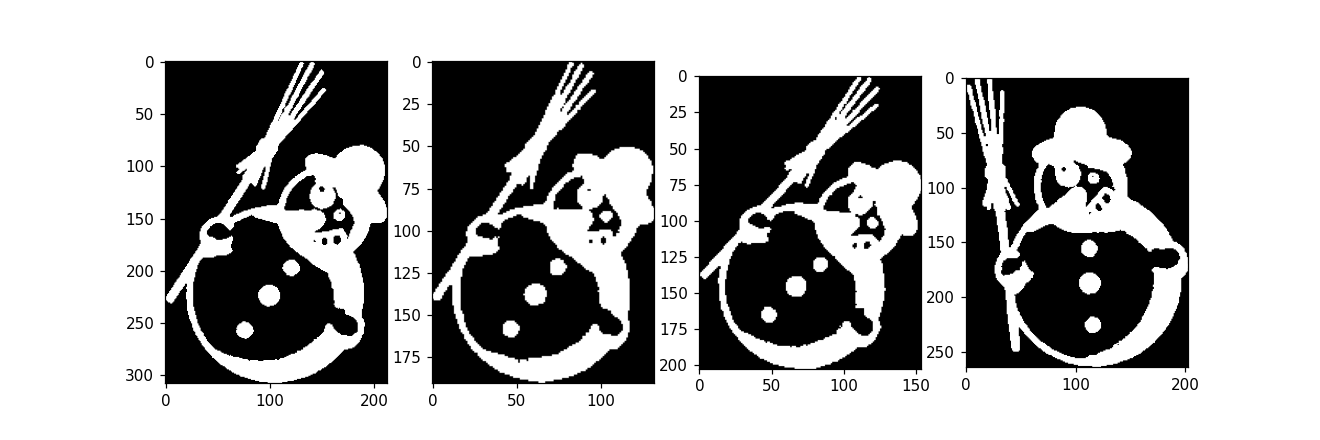

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [32]:
gray_threshold = 245

masks = np.array([
    np.array(img.sum(axis=-1) < (gray_threshold * 3),
             dtype=np.uint8)
    for img in X_train
], dtype=object)

_, ax_arr = plt.subplots(nrows=1, ncols=4, figsize=(12,4))

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:

    for i, mask in enumerate(masks[Y_train == class_]):
        ax_arr[i].imshow(mask, cmap='gray')

## Compute Hu Moments

In [33]:
import cv2 as cv

<IPython.core.display.Javascript object>


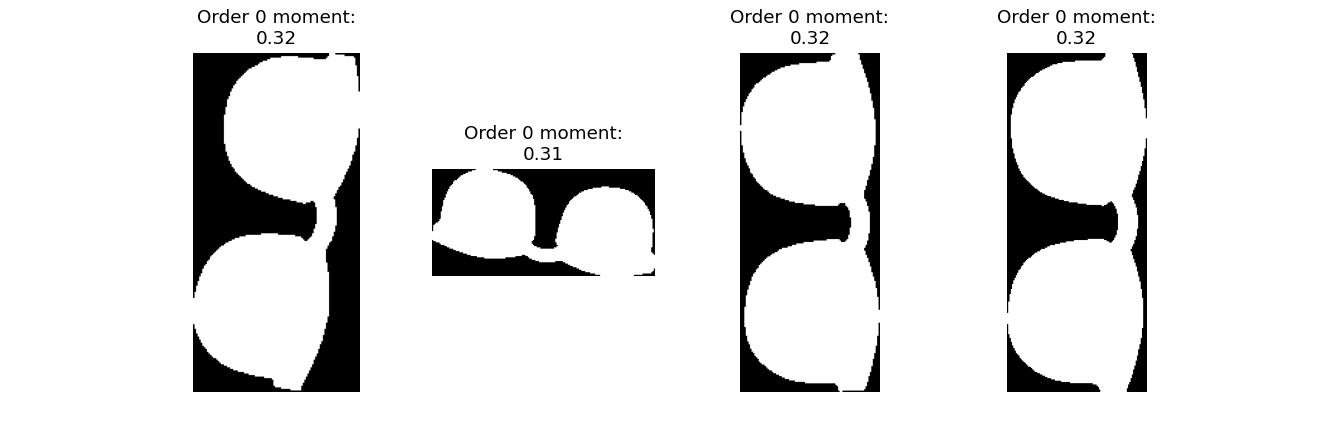

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [35]:
moments = np.array([cv.moments(mask, binaryImage=True) for mask in masks])
hu_moments = np.array([cv.HuMoments(mask_moments) for mask_moments in moments])
hu_moments = hu_moments.reshape(X_train.shape[0], 7)

_, ax_arr = plt.subplots(nrows=1, ncols=4, figsize=(12,4))

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    class_moments = hu_moments[Y_train == class_]
    for i, mask in enumerate(masks[Y_train == class_]):
        ax_arr[i].imshow(mask, cmap='gray')
        ax_arr[i].axis("off")
        ax_arr[i].set_title("Order 0 moment:\n{}".format(np.round(class_moments[i][0], 2)))

## What Hu moments looks like ?

In [36]:
hu_moments[0]

array([2.13136776e-01, 3.02005534e-03, 1.50452277e-03, 3.31433681e-05,
       6.31351195e-09, 6.70373392e-07, 3.86204106e-09])

We see that Hu Moments doesn't have comparable magnitudes this means that Hu Moments "weights" on classifiers decisions are really unbalanced, we can fix scaling by applying this formula:<br><br>
$$
    Hu_{i} = -sign(hu_{i})log(|hu_{i}|)
$$

In [37]:
scaled_moments = -(np.sign(hu_moments) * np.log(np.abs(hu_moments)))
scaled_moments[0]

array([ 1.54582118,  5.80248012,  6.49927953, 10.31466792, 18.88057375,
       14.21543098, 19.37207002])

## Classify with hu moments

In [38]:
scores, _, best_estimators = evaluate_classifiers_shape(classifiers, scaled_moments[:,:-1], Y_train)

for clf, scs in zip(classifiers, scores):
    print(f"{type(clf).__name__} scores:", np.mean(scs))

best_svc, best_knn, best_rnd, best_lsvc, best_dummy = best_estimators

/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVC scores: 0.8947368421052632
KNeighborsClassifier scores: 0.868421052631579
RandomForestClassifier scores: 0.9956140350877193
LinearSVC scores: 0.10087719298245613
DummyClassifier scores: 0.02631578947368421


/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


We can see that classifiers gives us really good results, this is because Hu moments are:
- Invariant to scale
- Invariant to rotation
- Invariant to translation
- Deterministic
- Compact

<IPython.core.display.Javascript object>


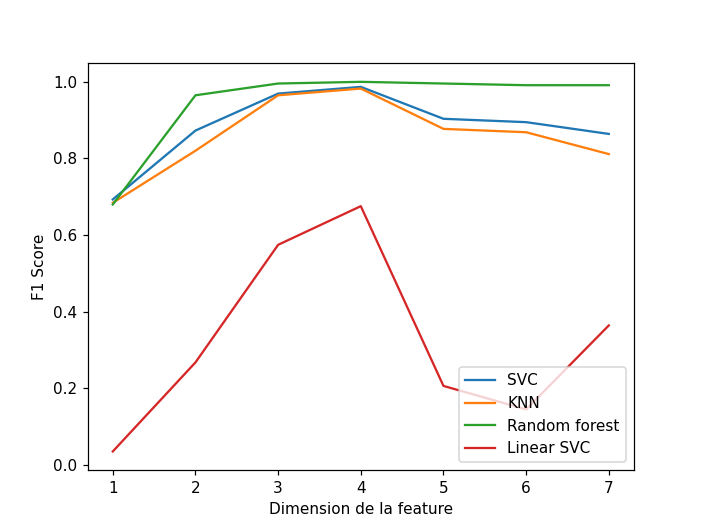

/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-

{'SVC': (4, 0.9868421052631579), 'KNN': (4, 0.9824561403508771), 'Random forest': (4, 1.0), 'Linear SVC': (4, 0.675438596491228)}


/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [57]:
_, ax = plt.subplots()
feature = [np.array(scaled_moments[:, :i]) for i in range(1, 8)]
best_dims = optimize_feature_dim(feature, range(1, 8), classifiers[:-1], ["SVC", "KNN", "Random forest", "Linear SVC"], Y_train, ax)
print(best_dims)

## Compute Aspect Ratios (AR)

Aspect Ratios (AR) are computed by finding the oriented bounding box of the mask and computing this formula:

$$
  Aspect\,ratio = \frac{Largest\,dimension}{Smallest\,dimension}
$$

Aspect ratios (width / height):


<IPython.core.display.Javascript object>


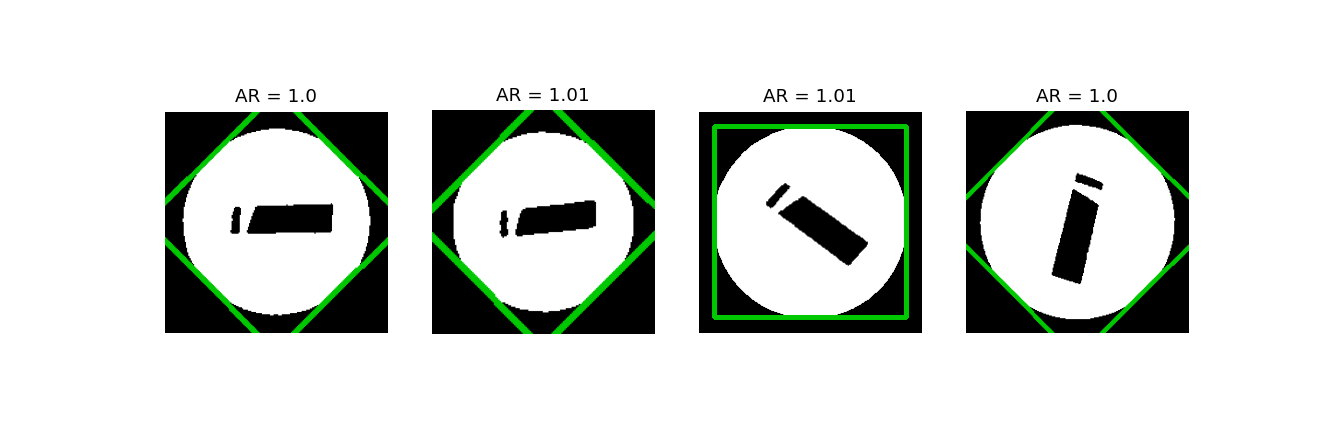

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [58]:
contours = np.array(
    [cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0] for mask in masks],
    dtype=object)
bounding_rects = np.array([cv.minAreaRect(max(contour, key=lambda c: cv.contourArea(c))) for contour in contours], dtype=object)
aspect_ratios = np.array([max(rect[1]) / min(rect[1]) for rect in bounding_rects])

print("Aspect ratios (width / height):")
offset = 15

_, ax_arr = plt.subplots(nrows=1, ncols=4, figsize=(12,4))

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    class_rects = bounding_rects[Y_train == class_]
    class_ratios = aspect_ratios[Y_train == class_].reshape(4)
    for i, mask in enumerate(masks[Y_train == class_]):
        to_show = cv.copyMakeBorder(mask * 255, offset, offset, offset,
                                    offset, cv.BORDER_CONSTANT, value=0)
        to_show = cv.cvtColor(to_show, cv.COLOR_GRAY2RGB)
        box = [np.int0(cv.boxPoints(class_rects[i]))]
        cv.drawContours(to_show, box, -1, (0, 200, 0), offset=(offset, offset), thickness=3)
        ax_arr[i].imshow(to_show)
        ax_arr[i].axis("off")
        ax_arr[i].set_title("AR = {}".format((round(class_ratios[i], 2))))
        
aspect_ratios = aspect_ratios.reshape(-1, 1);

## Classify classes with Aspect Ratios

In [41]:
scores, _, best_estimators = evaluate_classifiers_shape(classifiers, aspect_ratios, Y_train)

for clf, scs in zip(classifiers, scores):
    print(f"{type(clf).__name__} scores:", np.mean(scs))

best_svc, best_knn, best_rnd, best_lsvc, best_dummy = best_estimators

SVC scores: 0.5570175438596491
KNeighborsClassifier scores: 0.5307017543859649
RandomForestClassifier scores: 0.5131578947368421
LinearSVC scores: 0.06578947368421052
DummyClassifier scores: 0.017543859649122806


<IPython.core.display.Javascript object>


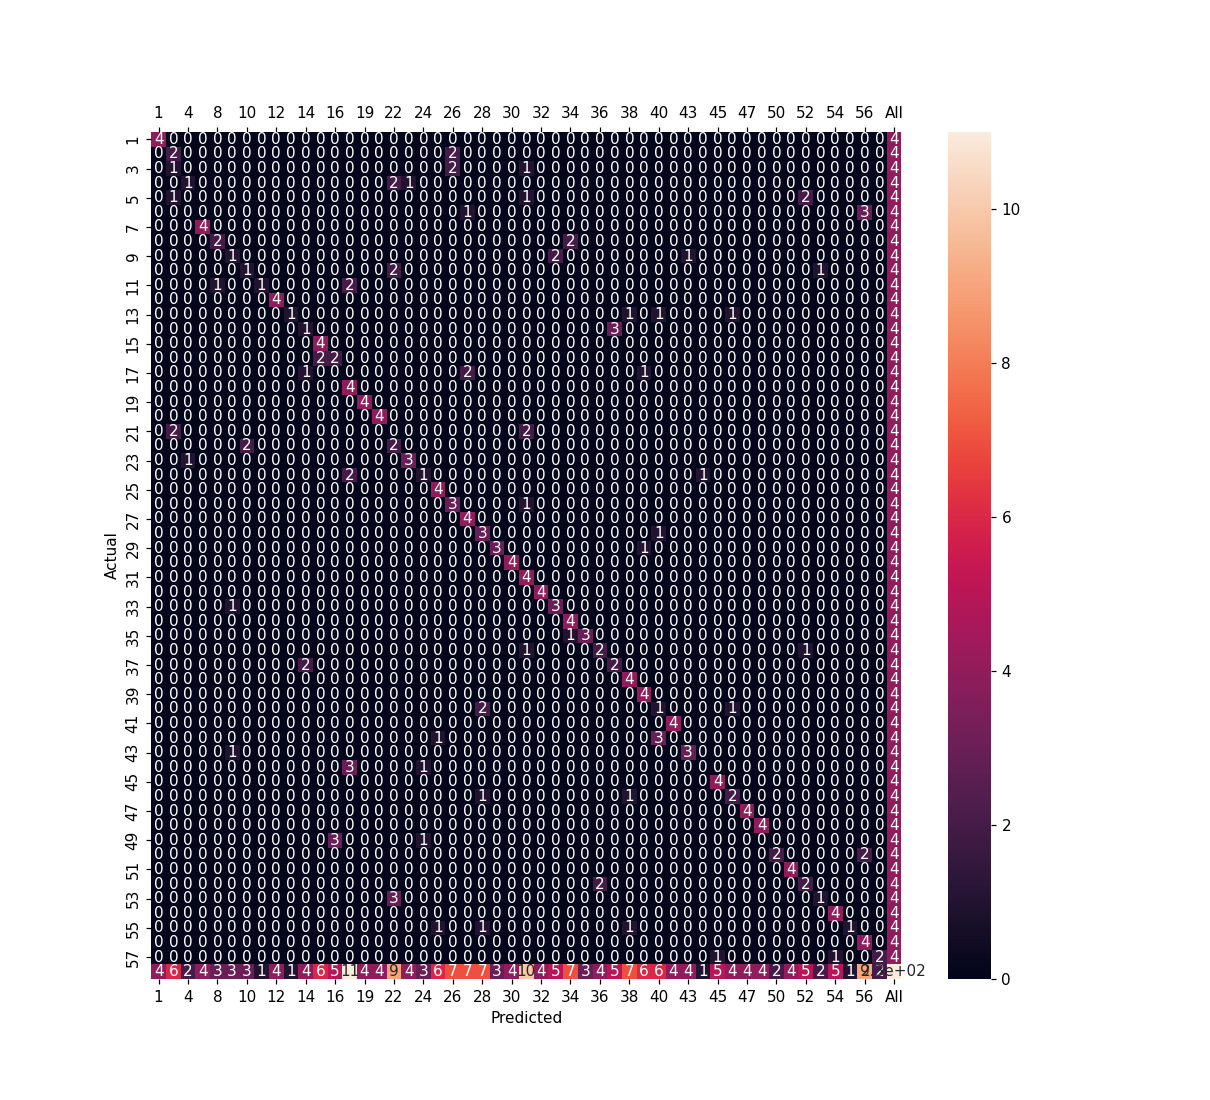

In [44]:
print_confusion_matrix(best_svc.predict(aspect_ratios), Y_train)

By looking at the confusion matrix we can see that classifiers are really struggling on certain classes.<br>
Let's take a look at classes 3 and 52:<br><br>
> **Class 3:**![notebook_resources/class_3_aspect_ratios.png](notebook_resources/class_3_aspect_ratios.png "class 3")<br>
**Class 52:**![notebook_resources/class_52_aspect_ratios.png](notebook_resources/class_52_aspect_ratios.png "class 52")<br>
We understand that the aspect ratio is not deterministic for images with same proportions.<br> This is therefore a pretty bad descriptor for our problem.

# Frequency classification attempt
We wanted to make an extra classifier using the frequency of an image so we tried with DCT algorithm.
### DCT properties
The DCT is a transformation which returns a coefficient matrix. This transformation is used in JPEG compression because a few of those coefficients are enough to describe the images with little loss. Thus, we thought that these coefficients were good classification features since they are compact and discriminative.

In [59]:
def get_dct(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imf = np.float32(img)/255.0
    dst = cv2.dct(imf)
    return np.uint8(dst)*255.0


dcts = np.array([get_dct(img) for img in X_train], dtype=object)

### How to gather most significant coefficients ? 

Another property of the Discret Cosine Transform is that significant coefficient are located in the top left corner of the coefficient matrix. This allows us to gather those coefficients by doing a diagonal traversal of the matrix.

In [60]:
def diagonalOrder(matrix, size):
    row, col = matrix.shape
    diag = []
    for line in range(1, (row + col)):
        if len(diag) >= size:
            break
        start_col = max(0, line - row)
        count = min(line, (col - start_col), row)
 
        for j in range(0, count):
            if len(diag) >= size:
                return diag
            diag.append(matrix[min(row, line) - j - 1]
                        [start_col + j])
    return diag
dct_coeffs = np.array([ diagonalOrder(dct, 150) for dct in dcts], dtype=float)

<IPython.core.display.Javascript object>


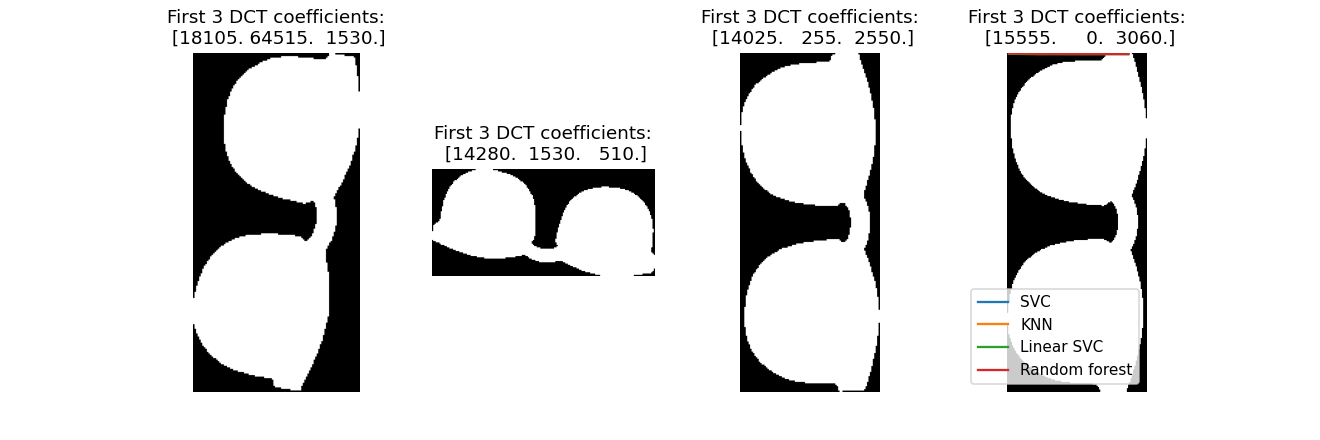

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

In [61]:
_, ax_arr = plt.subplots(nrows=1, ncols=4, figsize=(12,4))

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    class_dcts = dct_coeffs[Y_train == class_]
    for i, x in enumerate(masks[Y_train == class_]):
        ax_arr[i].imshow(x, cmap='gray')
        ax_arr[i].axis('off')
        ax_arr[i].set_title(f"First 3 DCT coefficients:\n {np.round(class_dcts[i][:3],2)}")

In [62]:
scores, _, best_estimators = evaluate_classifiers_shape(classifiers, dct_coeffs, Y_train)

for clf, scs in zip(classifiers, scores):
    print(f"{type(clf).__name__} scores:", np.mean(scs))

best_svc, best_knn, best_rnd, best_lsvc, best_dummy = best_estimators

SVC scores: 0.4736842105263158
KNeighborsClassifier scores: 0.2675438596491228
RandomForestClassifier scores: 0.49999999999999994
LinearSVC scores: 0.4868421052631579
DummyClassifier scores: 0.021929824561403508


<IPython.core.display.Javascript object>


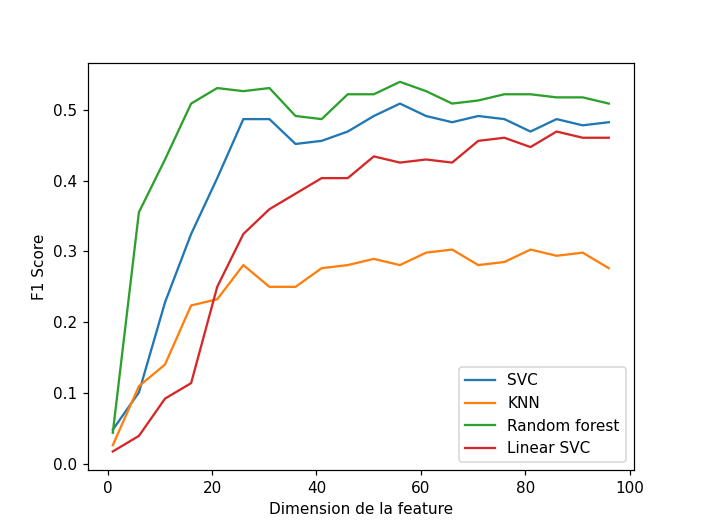

/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-

{'SVC': (12, 0.5087719298245614), 'KNN': (14, 0.3026315789473684), 'Random forest': (12, 0.5394736842105263), 'Linear SVC': (18, 0.4692982456140351)}


In [65]:
_, ax = plt.subplots()
feature = [np.array(dct_coeffs[:, :i]) for i in range(1, 100, 5)]
best_dims = optimize_feature_dim(feature, range(1, 100, 5), classifiers[:-1], ["SVC", "KNN","Random forest", "Linear SVC"], Y_train, ax)
print(best_dims)

### DCT evaluation

We can see that classifiers scores are low. This comes from the fact that DCT coefficients are not scale nor rotation nor translation invariant.

# Explicit fusion, early fusion on colors histograms and hu moments

## Colors histograms feature extraction

In [66]:
from sklearn.cluster import KMeans
from dobble_master_race.img_utils import mask_with_inner

nb_sample = 50000

def get_hist(color_map, nb_colors):
    hist = np.bincount(color_map, minlength=nb_colors)
    norm_hist = hist / hist.max()
    
    return norm_hist

def color_histograms_extraction(X, nb_colors, kmeans=None):  
    masks = np.array([mask_with_inner(img, 240) for img in X], dtype=object)
    nb_sample_per_image = nb_sample // len(X)
    
    if kmeans is None:
        sample_pxls = X[0][masks[0]][0] # Initialize arbitrary to be able to use np.vstack

        for img, mask in zip(X[1:], masks[1:]):
            pxls = img[mask]
            new_sample_pxls_id = np.random.choice(pxls.shape[0], size=nb_sample_per_image, replace=False)
            sample_pxls = np.vstack((sample_pxls, pxls[new_sample_pxls_id]))

        kmeans = KMeans(n_clusters=nb_colors, random_state=42)
        kmeans.fit(sample_pxls)
    
    color_maps = np.array([
        kmeans.predict(img[mask])
        for img, mask in zip(X, masks)
    ], dtype=object)
    
    colors_hists = np.array([get_hist(color_map, nb_colors) for color_map in color_maps])

    return colors_hists, kmeans

## Hu moments extraction

In [67]:
import cv2 as cv

gray_threshold = 245

def hu_moments_compute(X):
    shape_masks = np.array([
        np.array(img.sum(axis=-1) < (gray_threshold * 3), dtype=np.uint8)
        for img in X
    ], dtype=object)

    moments = np.array([cv.moments(mask, binaryImage=True) for mask in shape_masks])
    hu_moments = np.array([cv.HuMoments(mask_moments)[:-1] for mask_moments in moments])

    return -(np.sign(hu_moments) * np.log(np.abs(hu_moments))).reshape(hu_moments.shape[:-1])

## Early fusion

We concatenate each color histogram vector with it's associated hu_moments vector 

In [68]:
def merge_histo_hu(colors_histograms, hu_moments, nb_moments):
    return np.hstack((colors_histograms, hu_moments[:,:nb_moments]))

## Classifiers based on merged features

In [69]:
from sklearn.metrics import f1_score

def evaluate_clf_on_range(clf, nb_colors_range, moments_range, X, Y, cv):
    f1_scores = []
    hu_moments = hu_moments_compute(X)

    for nb_colors in nb_colors_range:
        f1_score_color = []
    
        # Don't compute histogram when we have zero color to samples 
        if nb_colors:
            color_histograms, _ = color_histograms_extraction(X, nb_colors)
        else:
            color_histograms = np.zeros((len(X), 0))
    
        for nb_moments in moments_range:
            # Skip when we have a merged features vector of lenght zero
            if nb_moments + nb_colors == 0:
                f1_score_color.append(np.zeros(len(classifiers)))
                continue
            merged = merge_histo_hu(color_histograms, hu_moments, nb_moments) 
            f1_score, _, _ = evaluate_classifiers_shape_histo(classifiers, merged, Y, cv)

            f1_score_color.append(f1_score)

        f1_scores.append(np.array(f1_score_color))

    return np.array(f1_scores)

In [70]:
# We skip the case where we nb_colors = 1 for the color quantization as it's not really relevant
precisions = evaluate_clf_on_range(classifiers, range(0, 20), range(7), X_train, Y_train, 4)

/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-

/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-

/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-

/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-

/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-

/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-

/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-

/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-

/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lioum/.cache/pypoetry/virtualenvs/dobble-master-race-V7ZoRYdP-

In [71]:
XS, YS = np.meshgrid(range(7), range(0, 20))

<IPython.core.display.Javascript object>


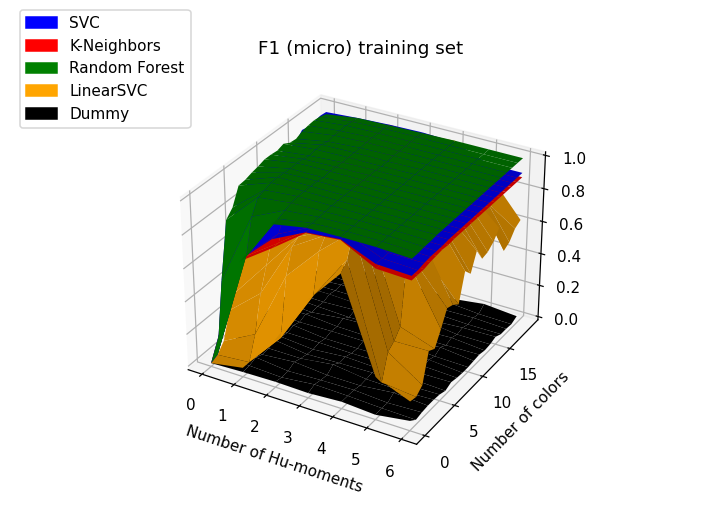

In [72]:
import matplotlib.patches as mpatches

fig = plt.figure()


ax = fig.add_subplot(projection='3d')

ax.set_title("F1 score (micro) training set")
ax.set_ylabel("Number of colors")
ax.set_xlabel("Number of Hu-moments")
ax.plot_surface(XS, YS, precisions[:,:,0], color='blue')
ax.plot_surface(XS, YS, precisions[:,:,1], color='red')
ax.plot_surface(XS, YS, precisions[:,:,2], color='green')
ax.plot_surface(XS, YS, precisions[:,:,3], color='orange')
ax.plot_surface(XS, YS, precisions[:,:,4], color='black')

legend_svc = mpatches.Patch(color='blue', label='SVC')
legend_kn = mpatches.Patch(color='red', label='K-Neighbors')
legend_rf = mpatches.Patch(color='green', label='Random Forest')
legend_lsvc = mpatches.Patch(color='orange', label='LinearSVC')
legend_dummy = mpatches.Patch(color='black', label='Dummy')

ax.legend(handles=[legend_svc, legend_kn, legend_rf, legend_lsvc,legend_dummy], bbox_to_anchor=(0.1, 1.15))

## Observation

We can clearly see that the Random Forest clearly outperforms the others 4 classifiers in every combination of colors and hu-moments (ranging from 0 to 19 and from 0 to 6 respectively).
We also observe that LinearSVC, SVC and KNeighbors classifiers seem to perform better with a smaller number of hu moments (2 to 4).
Linear SVC failed to give correct results on hu-moments and colors histograms alone and has overall way worse results than the others classifiers (apart from the dummy) and even failed to converge on certains combinations (cf. ConvergeWarnings on the computation of precision).

## Improvements

As we wanted to improve our results. We started to analyse the data we fed to the classifiers and we observed impactfull differences between our Hu moments features and our colors histograms features.

In [69]:
color_histograms, _ = color_histograms_extraction(X_train, 10)

In [70]:
np.var(color_histograms,axis=0)

array([0.11617946, 0.03267498, 0.1515926 , 0.07695665, 0.10865675,
       0.13087395, 0.12221275, 0.08995695, 0.08685994, 0.15554368])

In [71]:
np.var(hu_moments_compute(X_train), axis=0)

array([9.93951505e-02, 7.33390004e+00, 7.79211727e+00, 8.80631734e+00,
       3.50709579e+02, 1.66842338e+02])

There is more variance (multiple orders of magniture) on the hu moments features than on the colors histograms. This difference could affect classifiers based on distance computation as a variation in one of the feature of the color histogram would have less impact on the distance than a variation in the hu moments.

To correct this, we needed to have a similar variance between each feature distribution of the merged feature vector. So we needed to use the StandardScaler to make sure that each feature distribution variance equals to one.

To achieve this we transform our classifiers into pipelines each composed of a StandardScaler and the original classifier.

In [72]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

classifiers = [make_pipeline(StandardScaler(), clf) for clf in classifiers]

In [73]:
precisions = evaluate_clf_on_range(classifiers, range(0, 20), range(7), X_train, Y_train, 4)

<IPython.core.display.Javascript object>


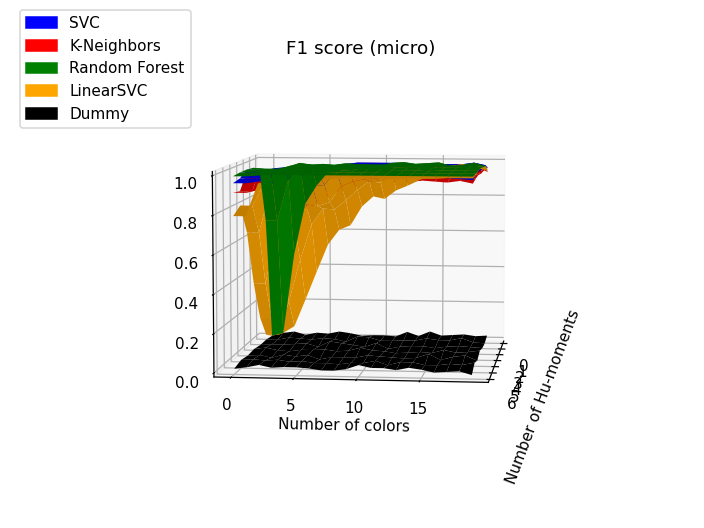

In [75]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.set_title("F1 score (micro) training set")
ax.set_ylabel("Number of colors")
ax.set_xlabel("Number of Hu-moments")
ax.plot_surface(XS, YS, precisions[:,:,0], color='blue')
ax.plot_surface(XS, YS, precisions[:,:,1], color='red')
ax.plot_surface(XS, YS, precisions[:,:,2], color='green')
ax.plot_surface(XS, YS, precisions[:,:,3], color='orange')
ax.plot_surface(XS, YS, precisions[:,:,4], color='black')

legend_svc = mpatches.Patch(color='blue', label='SVC')
legend_kn = mpatches.Patch(color='red', label='K-Neighbors')
legend_rf = mpatches.Patch(color='green', label='Random Forest')
legend_lsvc = mpatches.Patch(color='orange', label='LinearSVC')
legend_dummy = mpatches.Patch(color='black', label='Dummy')

ax.legend(handles=[legend_svc, legend_kn, legend_rf, legend_lsvc,legend_dummy], bbox_to_anchor=(0.1, 1.15))

## Observation

We can see a clear improvements from the previous results on every classifiers.The Linear SVC gives now similar results to the SVC and KNeighbors classifiers on combined feature vectors of length greater than 10.

F1-score: 0.8596491228070176


<IPython.core.display.Javascript object>


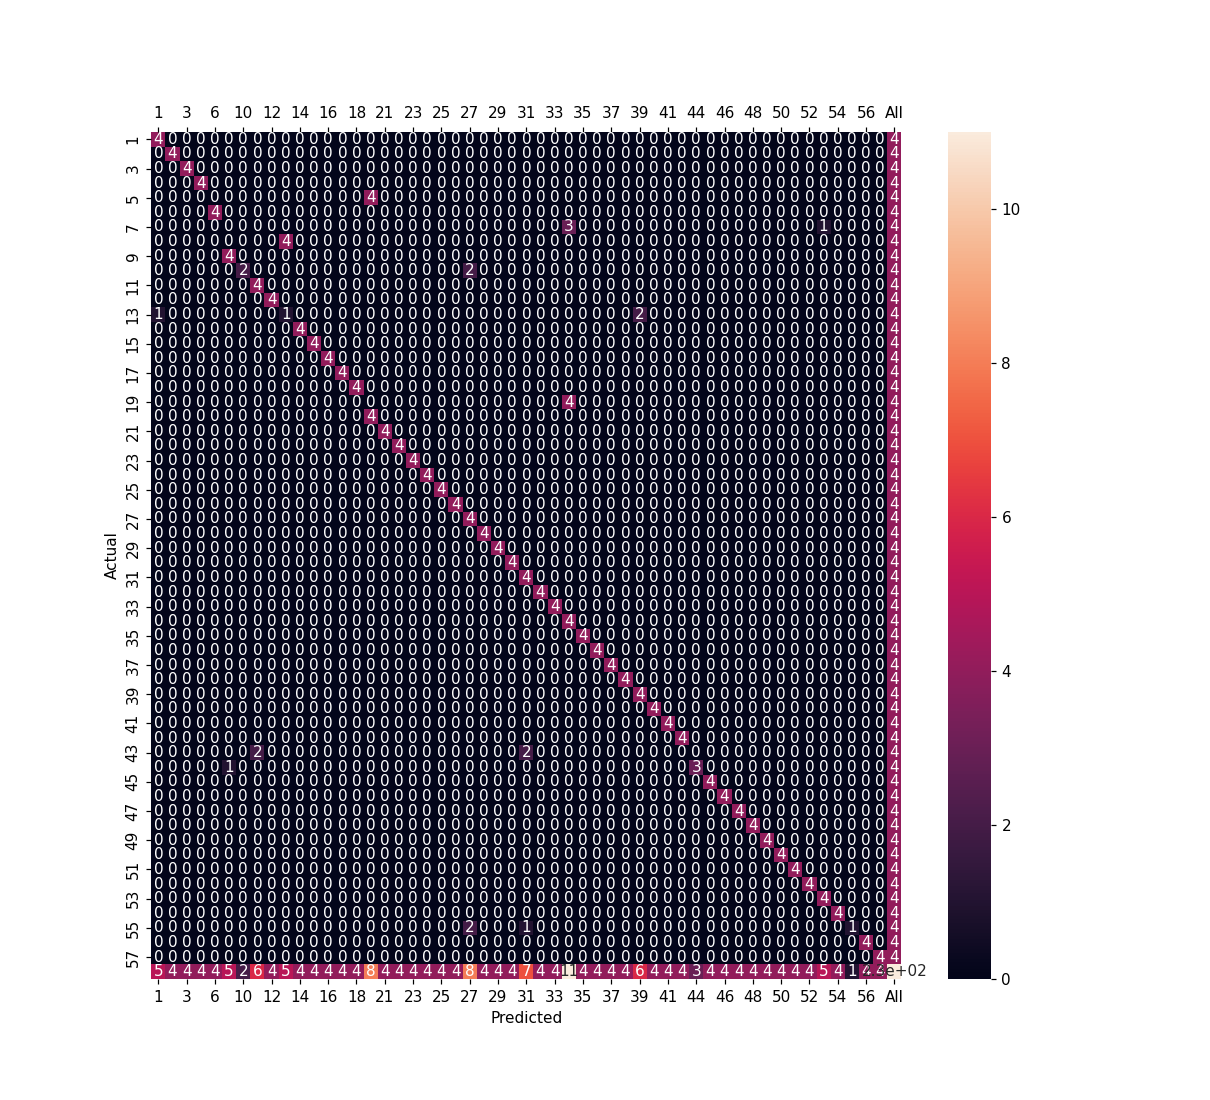

In [83]:
get_perf_on_cross_validation(best_lsvc, merged_train, Y_train)

## Validation

Evaluation on the test dataset

In [76]:
from sklearn.metrics import f1_score
from sklearn.base import clone

f1_scores = []
color_range = range(0, 20)

hu_moments_train = hu_moments_compute(X_train)
hu_moments_test = hu_moments_compute(X_test)

for nb_colors in color_range:
    f1_score_color = []
    
    # Don't compute histogram when we have zero color to samples 
    if nb_colors:
        color_histograms_train, kmeans = color_histograms_extraction(X_train, nb_colors)
        color_histograms_test, _ = color_histograms_extraction(X_test, nb_colors, kmeans)
    else:
        color_histograms_train = np.zeros((len(X_train), 0))
        color_histograms_test = np.zeros((len(X_test), 0))
        
    for nb_moments in range(7):
        # Skip when we have a merged features vector of lenght zero
        if nb_moments + nb_colors == 0:
            precisions_color.append(np.zeros(len(classifiers)))
            continue

        merged_train = merge_histo_hu(color_histograms_train, hu_moments_train, nb_moments)
        merged_test = merge_histo_hu(color_histograms_test, hu_moments_test, nb_moments)
        precisions_micro = []
        for clf in classifiers:
            precisions_micro.append(f1_score(Y_test, clone(clf).fit(merged_train, Y_train).predict(merged_test), average='micro'))
        precisions_color.append(precisions_micro)

    precisions.append(np.array(precisions_color))

precisions = np.array(precisions)
precisions

array([[[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.66666667, 0.68421053, 0.64912281, 0.03508772, 0.05263158],
        [0.94736842, 0.94736842, 0.9122807 , 0.19298246, 0.01754386],
        [1.        , 1.        , 1.        , 0.45614035, 0.01754386],
        [1.        , 1.        , 1.        , 0.77192982, 0.01754386],
        [0.98245614, 0.98245614, 1.        , 0.85964912, 0.01754386],
        [0.98245614, 0.94736842, 1.        , 0.85964912, 0.        ]],

       [[0.01754386, 0.01754386, 0.01754386, 0.01754386, 0.        ],
        [0.66666667, 0.68421053, 0.64912281, 0.03508772, 0.        ],
        [0.94736842, 0.94736842, 0.92982456, 0.19298246, 0.01754386],
        [1.        , 1.        , 1.        , 0.45614035, 0.01754386],
        [1.        , 1.        , 1.        , 0.77192982, 0.01754386],
        [0.98245614, 0.98245614, 1.        , 0.85964912, 0.01754386],
        [0.98245614, 0.94736842, 1.        , 0.85964912, 0.01754386]],

       [[0.42105

<IPython.core.display.Javascript object>


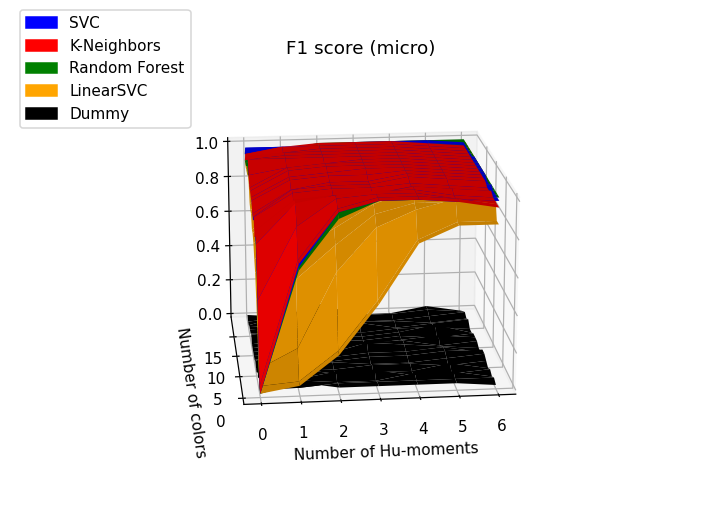

In [78]:
fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.set_title("F1 score (micro) test set")
ax.set_ylabel("Number of colors")
ax.set_xlabel("Number of Hu-moments")
ax.plot_surface(XS, YS, precisions[:,:,0], color='blue')
ax.plot_surface(XS, YS, precisions[:,:,1], color='red')
ax.plot_surface(XS, YS, precisions[:,:,2], color='green')
ax.plot_surface(XS, YS, precisions[:,:,3], color='orange')
ax.plot_surface(XS, YS, precisions[:,:,4], color='black')

legend_svc = mpatches.Patch(color='blue', label='SVC')
legend_kn = mpatches.Patch(color='red', label='K-Neighbors')
legend_rf = mpatches.Patch(color='green', label='Random Forest')
legend_lsvc = mpatches.Patch(color='orange', label='LinearSVC')
legend_dummy = mpatches.Patch(color='black', label='Dummy')

ax.legend(handles=[legend_svc, legend_kn, legend_rf, legend_lsvc,legend_dummy], bbox_to_anchor=(0.1, 1.15))

## Conclusion

We can observe that the classifiers perform the same as on the trainnig set, showing that there is no overfitting.